##Import json file which contain api key, from our local machine

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdraisulislamrimon","key":"16eff1274c6d56692e536125aa4e01e6"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

Dataset URL: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 2.57G/2.59G [00:21<00:00, 66.2MB/s]
100% 2.59G/2.59G [00:21<00:00, 130MB/s] 


In [11]:
!unzip ham1000-segmentation-and-classification.zip -d ham10000_seg

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_seg/masks/ISIC_0029321_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029322_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029323_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029324_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029325_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029326_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029327_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029328_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029329_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029330_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029331_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029332_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029333_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029334_segmentation.png  
  inflating: ham10000_seg/masks/ISIC_0029335_segmenta

In [12]:
!ls

ham10000_seg  ham1000-segmentation-and-classification.zip  sample_data


In [13]:
!ls ham10000_seg

GroundTruth.csv  images  masks


In [15]:
import pandas as pd

meta = pd.read_csv("ham10000_seg/GroundTruth.csv")
print(meta.head())

# Define classes in order
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
cls2id = {c: i for i, c in enumerate(classes)}
print("Class mapping:", cls2id)

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
Class mapping: {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}


In [16]:
import pandas as pd
import os

classes = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
cls2id = {c:i for i,c in enumerate(classes)}

df = pd.read_csv("ham10000_seg/GroundTruth.csv")

# YOLO expects a txt file per image
save_dir = "ham10000_seg/labels"
os.makedirs(save_dir, exist_ok=True)

for idx, row in df.iterrows():
    # get numeric class
    label = row[classes].idxmax()
    class_id = cls2id[label]

    # YOLO requires bounding box in normalized x_center, y_center, width, height
    # Since we want whole image, we use 0.5,0.5,1.0,1.0
    txt_path = os.path.join(save_dir, row['image'] + ".txt")
    with open(txt_path, 'w') as f:
        f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

In [18]:
import shutil
from sklearn.model_selection import train_test_split
import os

img_dir = "ham10000_seg/images"
label_dir = "ham10000_seg/labels"

images = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

for split, imgs in zip(["train","val"], [train_imgs, val_imgs]):
    os.makedirs(f"dataset/images/{split}", exist_ok=True)
    os.makedirs(f"dataset/labels/{split}", exist_ok=True)

    for img_name in imgs:
        # Copy image
        shutil.copy(os.path.join(img_dir, img_name), f"dataset/images/{split}/")

        # Copy corresponding label ONLY if it exists
        label_name = img_name.replace(".jpg", ".txt")
        src_label = os.path.join(label_dir, label_name)
        dst_label = os.path.join(f"dataset/labels/{split}/", label_name)

        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)
        else:
            print(f"Label not found for {img_name}, skipping...")


In [19]:
yaml_content = """
path: dataset  # root folder of your dataset
train: images/train
val: images/val

nc: 7  # number of classes
names: ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
"""

with open("skin_cancer.yaml", "w") as f:
    f.write(yaml_content)

print("skin_cancer.yaml created successfully!")

skin_cancer.yaml created successfully!


In [20]:
!cat skin_cancer.yaml


path: dataset  # root folder of your dataset
train: images/train
val: images/val

nc: 7  # number of classes
names: ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']


In [21]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


In [25]:
!wget https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12n.pt

--2025-09-21 15:49:08--  https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12n.pt
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/928546208/99db71db-0946-4c10-94a0-b54baf471037?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-21T16%3A42%3A53Z&rscd=attachment%3B+filename%3Dyolov12n.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-21T15%3A41%3A58Z&ske=2025-09-21T16%3A42%3A53Z&sks=b&skv=2018-11-09&sig=P7S222yRt8tdEcWTA13poFIUB%2F%2BXakiyoDe2waoO9xQ%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODQ3MDA0OCwibmJmIjoxNzU4NDY5NzQ4LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLm

##Train the model

In [26]:
from ultralytics import YOLO

# Load the pre-trained YOLOv12 model
model = YOLO("yolov12n.pt")

# Train the model
model.train(
    data="skin_cancer.yaml",  # Path to your dataset YAML
    epochs=20,                # Number of epochs
    imgsz=224,                # Image size
    batch=16,                 # Batch size
    project="yolo_skin",      # Project directory
    name="exp1",              # Experiment name
    exist_ok=True             # Overwrite existing experiment
)

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=skin_cancer.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e2a084b860>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [27]:
# Evaluate the model
results = model.val()

# Print the results
print(results)

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,558,093 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3686.8±564.5 MB/s, size: 246.5 KB)
val: Scanning /content/dataset/labels/val.cache... 2003 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2003/2003 3.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 126/126 8.9it/s 14.2s
                   all       2003       2003      0.685      0.592      0.605      0.595
                   MEL        233        233      0.475      0.627      0.533      0.521
                    NV       1330       1330      0.861      0.966      0.971      0.969
                   BCC        106        106      0.665      0.654      0.733      0.724
                 AKIEC         62         62      0.386      0.371       0.35       0.34
                   BKL        209        

In [28]:
from ultralytics import YOLO

# Load the best weights from training
model = YOLO("/content/yolo_skin/exp1/weights/best.pt")

###Predict on single image


image 1/1 /content/dataset/images/val/ISIC_0024333.jpg: 192x224 1 MEL, 1 BKL, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 224)


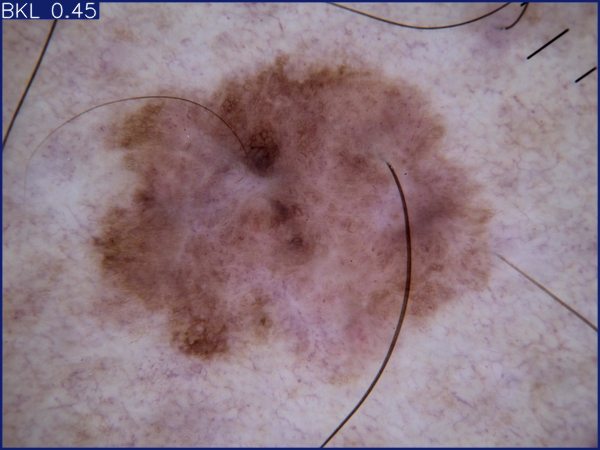

In [44]:
results = model.predict("/content/dataset/images/val/ISIC_0024333.jpg")

# Since results is a list, access the first element
results[0].show()  # Display the image with bounding boxes

###Predict on a folder of images

In [33]:
results = model.predict("/content/dataset/images/val/*")



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2003 /content/dataset/images/val/ISIC_0024310.jpg: 192x224 1 MEL, 21.7ms
image 2/2003 /content/dataset/images/val/ISIC_0024311.jpg: 192x224 1 NV, 15.4ms
image 3/2003 /content/dataset/images/val/ISIC_0024312.jpg: 192x224 1 BKL, 16.0ms
image 4/2003 /content/dataset/images/val/ISIC_0024331.jpg: 192x224 1 BCC, 15.0ms
image 5/2003 /content/dataset/images/val/ISIC_0024333.jpg: 192x224 1 MEL, 1 BKL, 15.1ms
image 6/2003 /content/dataset/images/val/ISIC

In [39]:
metrics = model.val(data="/content/skin_cancer.yaml", split="val")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3387.3±914.5 MB/s, size: 294.1 KB)
val: Scanning /content/dataset/labels/val.cache... 2003 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2003/2003 4.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 126/126 8.6it/s 14.6s
                   all       2003       2003      0.685      0.592      0.605      0.595
                   MEL        233        233      0.475      0.627      0.533      0.521
                    NV       1330       1330      0.861      0.966      0.971      0.969
                   BCC        106        106      0.665      0.654      0.733      0.724
                 AKIEC         62         62      0.386      0.371       0.35       0.34
                   BKL        209        209      0.473      0.761      0.622      0.608
                    DF         26   

##Confusion Matrix & Curves

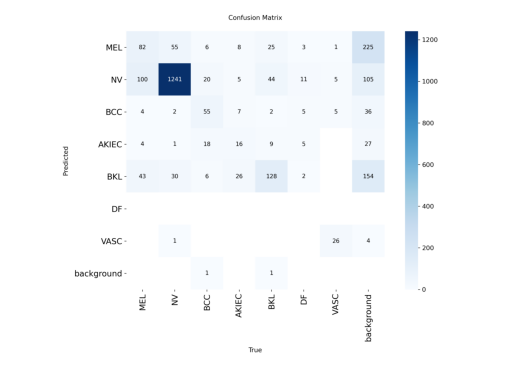

In [40]:
import matplotlib.pyplot as plt
import cv2

# Load confusion matrix
img = cv2.imread("/content/runs/detect/val2/confusion_matrix.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

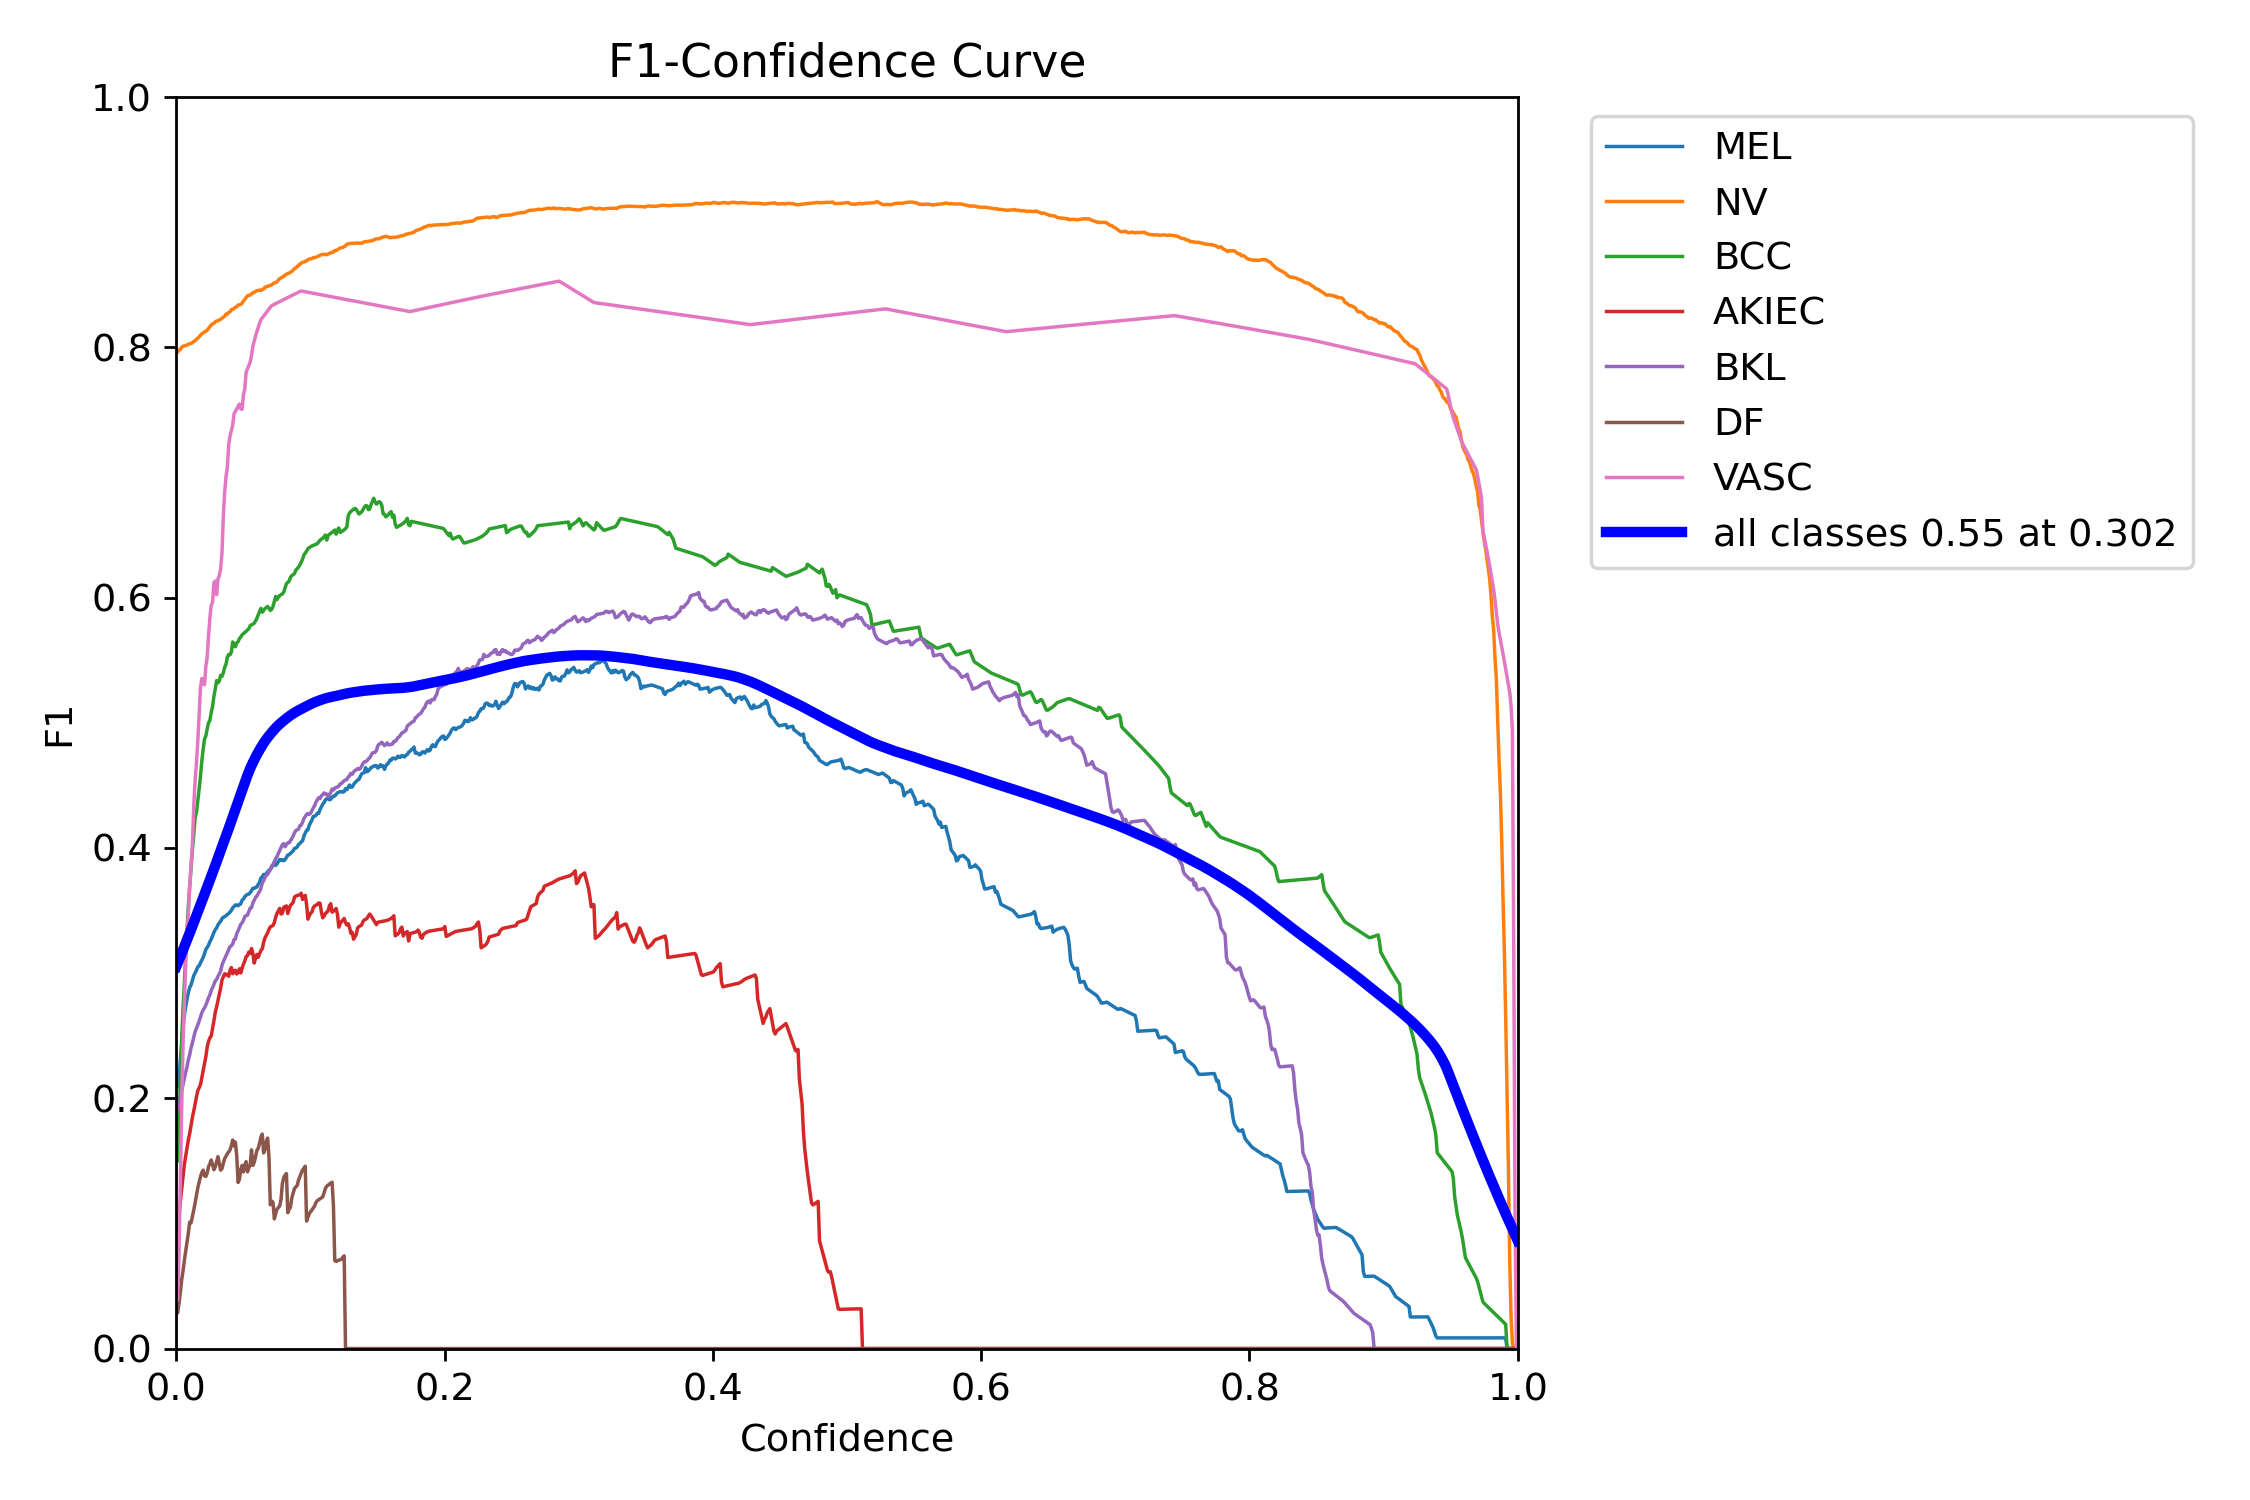

In [45]:
from IPython.display import Image
Image("/content/runs/detect/val2/BoxF1_curve.png")


image 1/1 /content/ham10000_seg/images/ISIC_0027556.jpg: 480x640 1 NV, 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


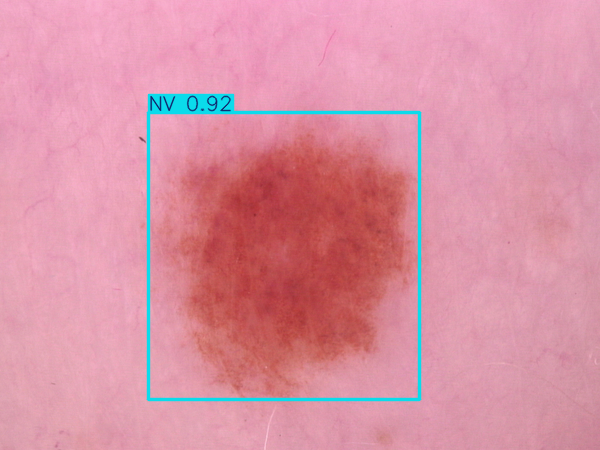

'results_ISIC_0027556.jpg'

In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs/detect/train2/weights/best.pt")

# Run inference on a test image
results = model("/content/ham10000_seg/images/ISIC_0027556.jpg")

# results is a list, get the first element
results[0].show()   # Display the prediction
results[0].save()   # Save the output image
